<center><img src="images/clothing.jpg"></center>

Welcome to the world of e-commerce, where customer feedback is a goldmine of insights! In this project, you'll dive into the Women's Clothing E-Commerce Reviews dataset, focusing on the 'Review Text' column filled with direct customer opinions.

Your mission is to use text embeddings and Python to analyze these reviews, uncover underlying themes, and understand customer sentiments. This analysis will help improve customer service and product offerings.

## The Data

You will be working with a dataset specifically focusing on customer reviews. Below is the data dictionary for the relevant field:

## womens_clothing_e-commerce_reviews.csv

| Column        | Description                           |
|---------------|---------------------------------------|
| `'Review Text'` | Textual feedback provided by customers about their shopping experience and product quality. |

Armed with access to powerful embedding API services, you will process the reviews, extract meaningful insights, and present your findings.

Let's get started!

## Install useful libraries

In [179]:
# Run this cell to install ChromaDB if desired
try:
    assert version('chromadb') == '0.4.17'
except:
    !pip install chromadb==0.4.17
try:
    assert version('pysqlite3') == '0.5.2'
except:
    !pip install pysqlite3-binary==0.5.2
__import__('pysqlite3')
import sys
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')
import chromadb
import pandas as pd
import re
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import openai
from scipy.spatial import distance
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction
import os

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


## Load the dataset
Load data and perform basic data checks to ensure you are using relevant data for the analysis

In [180]:
# Load the dataset
reviews = pd.read_csv("womens_clothing_e-commerce_reviews.csv")
review_text = reviews["Review Text"].dropna()

# Display the first few entries
review_text.head()

sample_text = review_text[0]

Text(0, 0.5, 't-SNE feature 2')

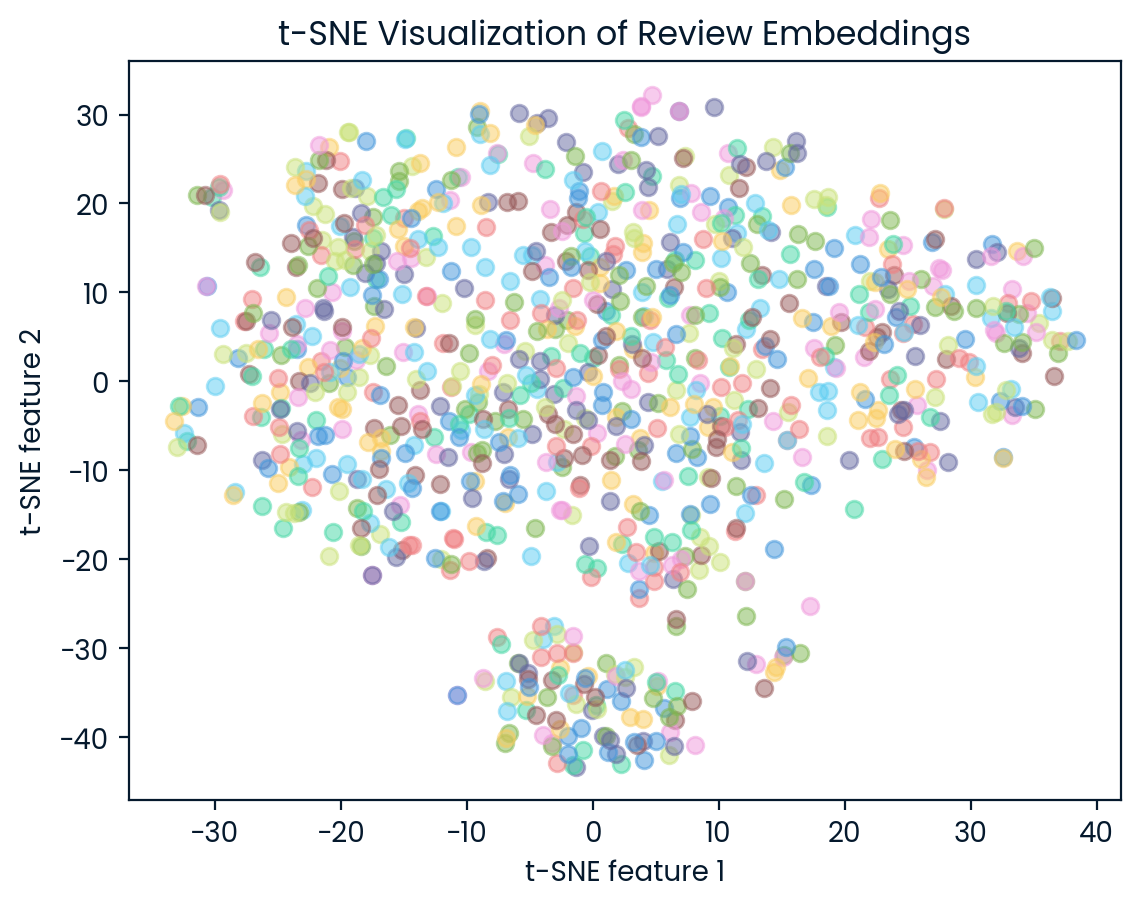

In [181]:
client = openai.OpenAI();

embedding_model = "text-embedding-3-small"

embeddings = client.embeddings.create(
    input=review_text.tolist(),
    model=embedding_model
).model_dump()

embeddings = [embeddings["embedding"] for embeddings in embeddings["data"]]

# Apply t-SNE for dimensionality reduction
def apply_tsne(embeddings):
    tsne = TSNE(n_components=2, random_state=0)
    return tsne.fit_transform(embeddings)

embeddings_2d = apply_tsne(np.array(embeddings))

for i, point in enumerate(tsne_results):
    plt.scatter(point[0], point[1], alpha=0.5)
plt.title("t-SNE Visualization of Review Embeddings")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")
#plt.show()
    

In [182]:
#Feedback Categorization

categories = ['quality', 'fit', 'style', 'comfort']

category_response = client.embeddings.create(
    input = categories,
    model=embedding_model
).model_dump()

category_embedding = [embeddings["embedding"] for embeddings in category_response["data"]]

category_embedding2d = np.array(category_embedding)

#print(category_embedding2d.shape)

In [183]:
def category_feeds(text_embedding, category_embedding):
    similarity = [{"distance": distance.cosine(text_embedding, cat_embed), "index": i}for i, cat_embed in enumerate(category_embedding)]
    closest = min(similarity, key=lambda x:x["index"])
    return category[closest["index"]]
    
feedback_category = [categorize_feedback(embedding,category_embedding) for embedding in embeddings]

In [184]:
# create and clean any exisiting collections

client = chromadb.PersistentClient()
client.delete_collection(name="review_embeddings_v2.1")


In [185]:
# Define vector database
review_embeddings_db = client.create_collection(
    name="review_embeddings_v2.1",
    embedding_function=OpenAIEmbeddingFunction(model_name="text-embedding-3-small", api_key=os.environ["OPENAI_API_KEY"]))

# Store embeddings inside vector database
review_embeddings_db.add(
    documents=review_text.tolist(),
    ids=[str(i) for i in range(len(review_text))]
)

In [186]:
#Similarirty search function

def sim_search_funct(input, db, n):
    collection = client.get_collection(
        name="review_embeddings_v2.1",
        embedding_function=OpenAIEmbeddingFunction(model_name = embedding_model, api_key=os.environ["OPENAI_API_KEY"]))
    
    results = collection.query(
        query_texts = input,
        n_results = n  
    )
    return results

In [187]:
#example review

most_similar_reviews = sim_search_funct(sample_text, embeddings_db, n=3)["documents"][0]

print(most_similar_reviews)


['Absolutely wonderful - silky and sexy and comfortable', 'Very comfortable and versatile. got lots of compliments.', 'This is a very comfortable and sexy sleep dress, the way it drapes. i can see that the type of fabric is not suitable for out and about activities and can catch on snags, etc. very easily. once i relegated it to the nightgown category it became my favorite item to wear and lounge in.']


In [188]:
#delete collection
client.delete_collection(name="review_embeddings_v2.1")